In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

import os

#get my written functions
from userfuncs import prepare_dataframe, find_borders_nan_intervals, count_frequency, count_missing

In [2]:
sns.set(style='darkgrid')

In [3]:
path = os.path.join('data', 'prioksk_ter_2020.xlsx')
df = pd.read_excel(path)
df.head(2)

,YY,MM,DD,ST,PL,MD,DU,TSP,Q_TSP,SO2,...,Q_CD,NO2,Q_NO2,NO,Q_NO,Примечание,с аэрозол,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,83.0,12.0,6.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,мг/г,NaN,NaN,NaN
1,83.0,12.0,7.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Preparation of data**

In [4]:
drop_cols = ['ST', 'PL', 'MD', 'DU', 'Примечание', 'с  аэрозол', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27']

In [5]:
print(f"Shape before preparation: {df.shape}\n")
df, wrong_dates = prepare_dataframe(df, drop_cols, return_wrong_dates=True)
print(f"\nShape after preparation: {df.shape}")

Shape before preparation: (12128, 28)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 
Got wrong date YY MM DD, it'll be dropped
  



Shape after preparation: (12068, 16)


Check wrong dates

In [6]:
for v in wrong_dates:
    print(f"{v[0]}/{v[1]}/{v[2]}")

1998/9/31


Check if all dates are unique

In [7]:
for val, freq in count_frequency(df.index.tolist()):
    if freq > 1:
        print(val, freq)

1994-04-02 00:00:00 2
1995-09-27 00:00:00 2
1995-11-28 00:00:00 2
1998-09-20 00:00:00 2


Since there're nonunique dates, they should be preprocessed
<br>
I'll keep only the first appearance

In [8]:
df = df.loc[~df.index.duplicated(keep='first')]

In [9]:
#Columns that can be explored not starting with "Q_"
use_cols = [col for col in df.columns if not col.startswith('Q_')]
df = df[use_cols]

**Get some information about data**

In [15]:
xx = count_missing(df, is_print=True, return_df=True)
#xx.to_csv('data_info.csv', sep=',', index=False)

                       Some information about data
----------------------------------------------------------------------
Element | Count NaN | Count no-NaN | First valid date| Last valid date
----------------------------------------------------------------------
TSP        4695           7099        1985-01-03        2017-09-30
SO2         943          10377        1986-06-01        2017-09-30
SO4        4617           7177        1985-01-03        2017-09-30
HG         6694           4359        1987-03-01        2017-09-28
PB         6581           5481        1983-12-06        2017-09-28
CD         6637           5425        1983-12-06        2017-09-28
NO2        2752           4539        1997-08-02        2017-09-30
NO        12064              0              None              None

P.S. valid date means that before or after this date there're only missing values.
Of course nonvalid dates are omitted


In [95]:
df = df.drop(['NO'], axis=1)

**Bar plot for missing and non-missing values**

First and last missing values are obviously dropped

In [130]:
bardf = pd.DataFrame({'elem' : list(df.columns) + list(df.columns)
                      , 'is_nan': ['missing']*len(df.columns) + ['non-missing']*len(df.columns)
                      , 'value' : [None]*2*len(df.columns)
                     })

for col in df.columns:
    ts = df[[col]].copy()
    fir_ix = ts.index.get_loc(ts[col].first_valid_index())
    last_ix = ts.index.get_loc(ts[col].last_valid_index())
    ts = ts.iloc[fir_ix:last_ix+1, :]
    bardf.loc[(bardf['elem']==col) & (bardf['is_nan']=='non-missing'), 'value'] = ts.notnull().sum().values[0]
    bardf.loc[(bardf['elem']==col) & (bardf['is_nan']=='missing'), 'value'] = ts.isna().sum().values[0]
    
#create pivot table for convenient plotting
bardf = bardf.pivot(index='elem', columns='is_nan', values='value')

In [131]:
bardf

is_nan,missing,non-missing
elem,,
CD,6637,5425
HG,6694,4359
NO2,2752,4539
PB,6581,5481
SO2,943,10377
SO4,4617,7177
TSP,4695,7099


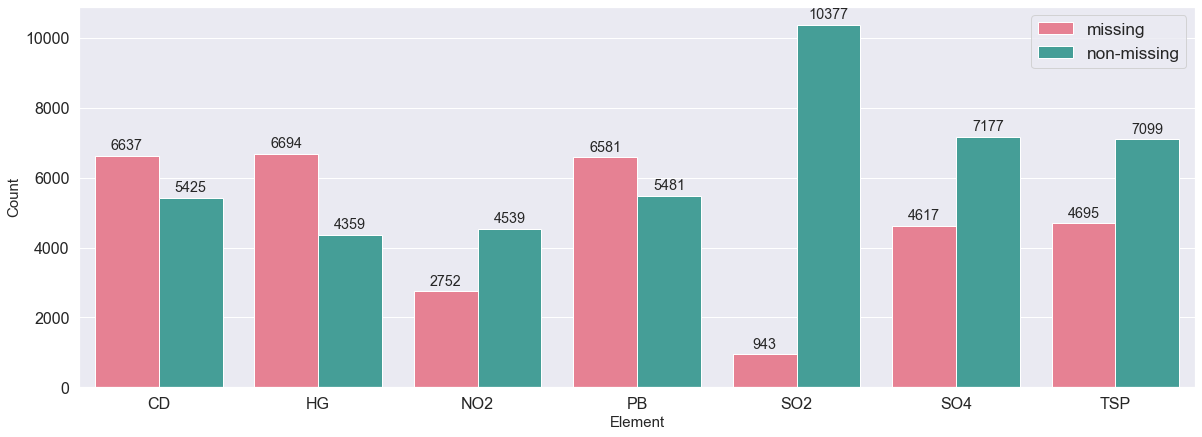

In [186]:
plt.figure(figsize=(20,7))
stacked = bardf.stack().reset_index().rename(columns={0:'count'})
sbar = sns.barplot(x=stacked['elem'], y=stacked['count'], hue=stacked['is_nan'], palette=sns.color_palette('husl', 2))

for p in sbar.patches:
    sbar.annotate(int(p.get_height())
                  , (p.get_x() + p.get_width() / 2, p.get_height())
                  , ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points'
                  , fontsize='large')


plt.legend(loc='best', fontsize='x-large')
plt.ylabel('Count', fontsize=15)
plt.xlabel('Element', fontsize=15)
plt.tick_params(labelsize=16)
plt.show()

**Find borders of nan intervals for all elements**

First and last missing values for time series are obviously omitted

In [100]:
d1 = {}

In [101]:
for col in df.columns:
    d1[col] = find_borders_nan_intervals(df, col)

**Number of nan intervals with equal lengths**

1-st value is a length of nan interval
<br>
2-d value is count of intervals with a such length (=1-st val) in the series

In [102]:
d2 = {}

In [103]:
for k, v in d1.items():
    l = count_frequency([x[2] for x in v])
    d2[k] = l

**Check equal lengths of nan intervals among all elements**

I'd like to see how many and what lengths of nan intervals there are among all elements

In [58]:
s = sorted(set([v[0] for v in list(itertools.chain(*list(d2.values())))]))
for ss in s:
    print(ss, end=' ')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 39 42 43 46 47 52 54 61 62 63 64 72 82 92 93 94 95 99 129 273 284 304 431 582 

**Create table like pivot one**

In [59]:
subtable = pd.DataFrame(columns=df.columns, index=s)
subtable.index = subtable.index.rename('len nan interval')

In [60]:
for k, v in d2.items():
    for vv in v:
        subtable.loc[vv[0], k] = vv[1]

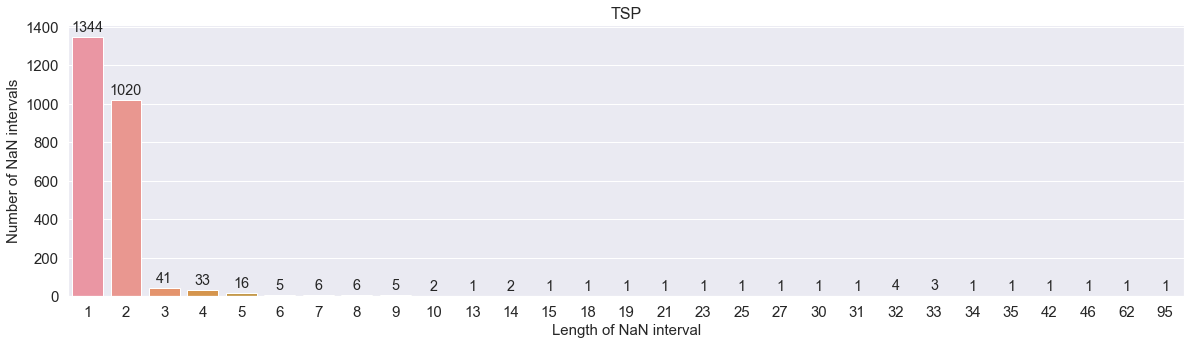

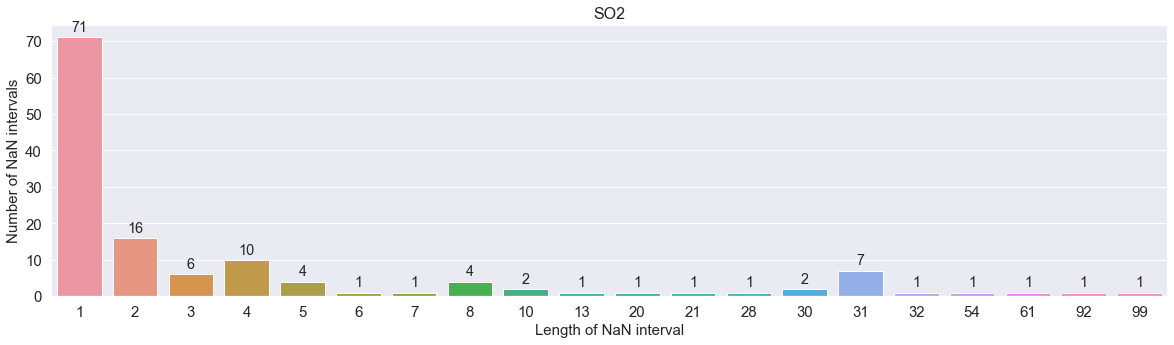

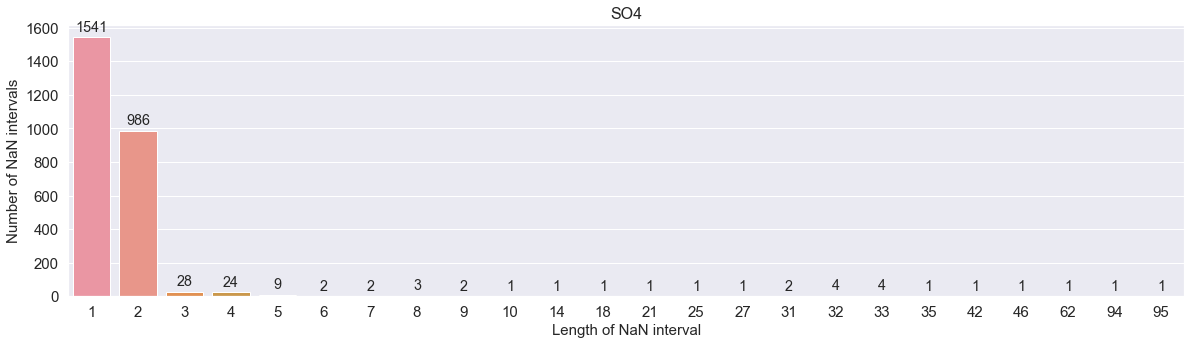

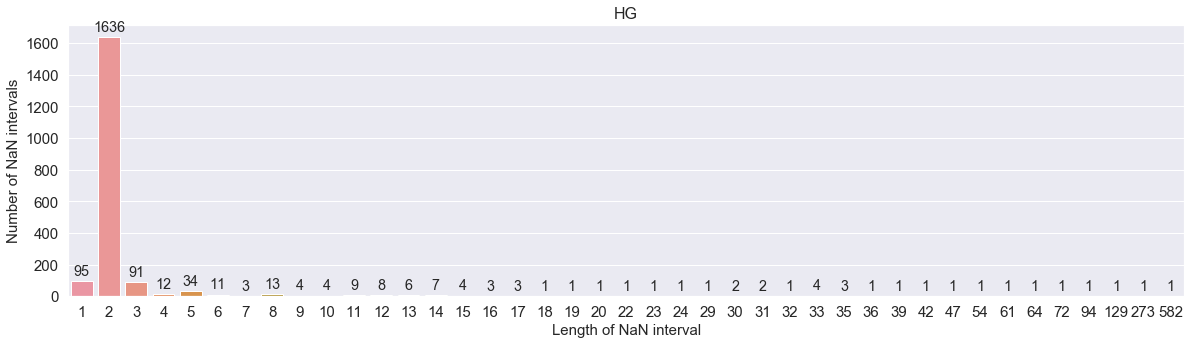

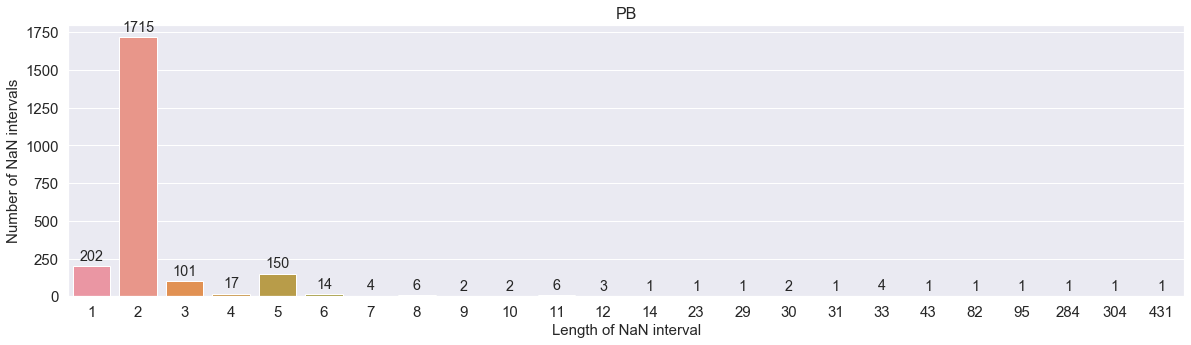

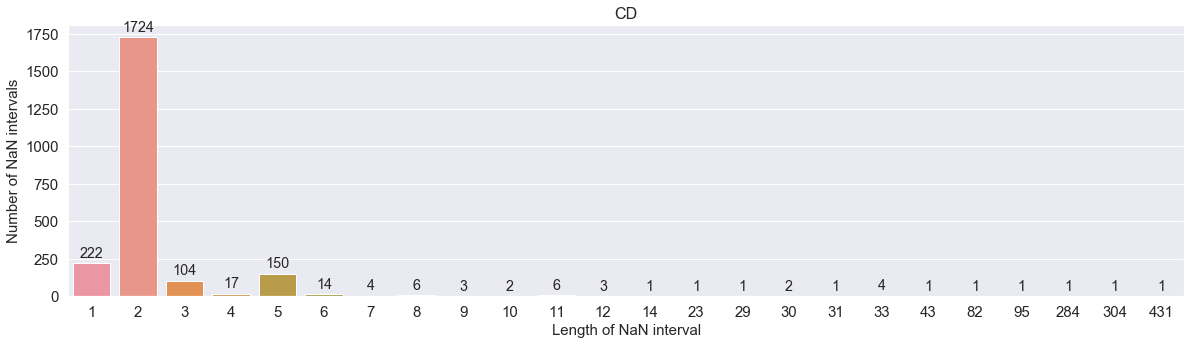

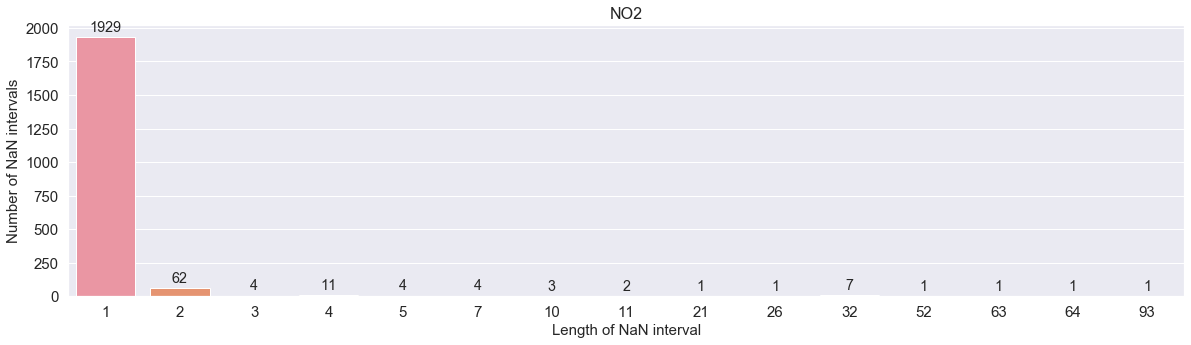

In [118]:
for col in subtable.columns:
    fig = plt.figure(figsize=(20, 5))
    t = subtable[col].dropna()
    sbar = sns.barplot(t.index, t.to_numpy())
    for p in sbar.patches:
        sbar.annotate(int(p.get_height())
                      , (p.get_x() + p.get_width() / 2, p.get_height())
                      , ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points'
                      , fontsize='large')
        
    plt.tick_params(labelsize=15)
    plt.title(col, fontsize=16)
    plt.xlabel('Length of NaN interval', fontsize=15)
    plt.ylabel('Number of NaN intervals', fontsize=15)
        
plt.show()

**Plot graphics for all elements**

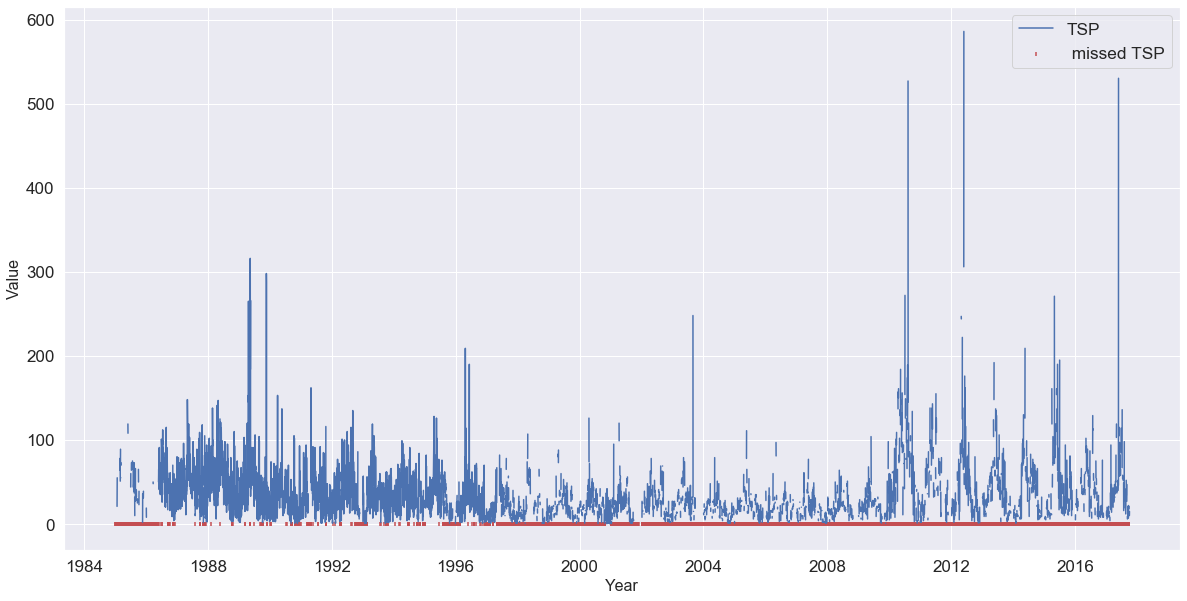

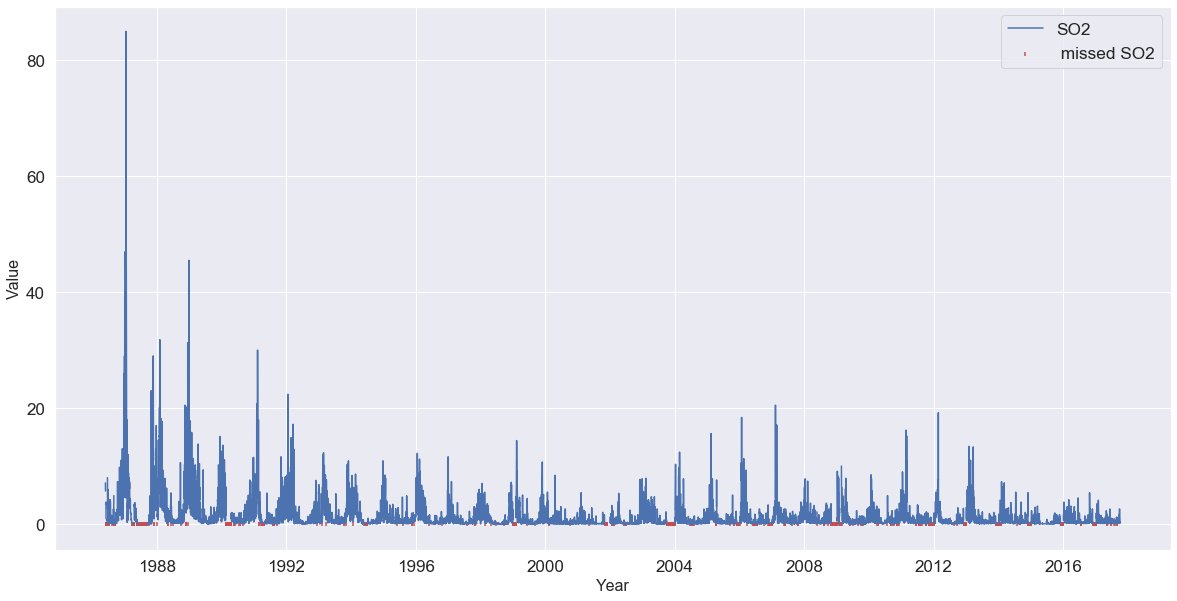

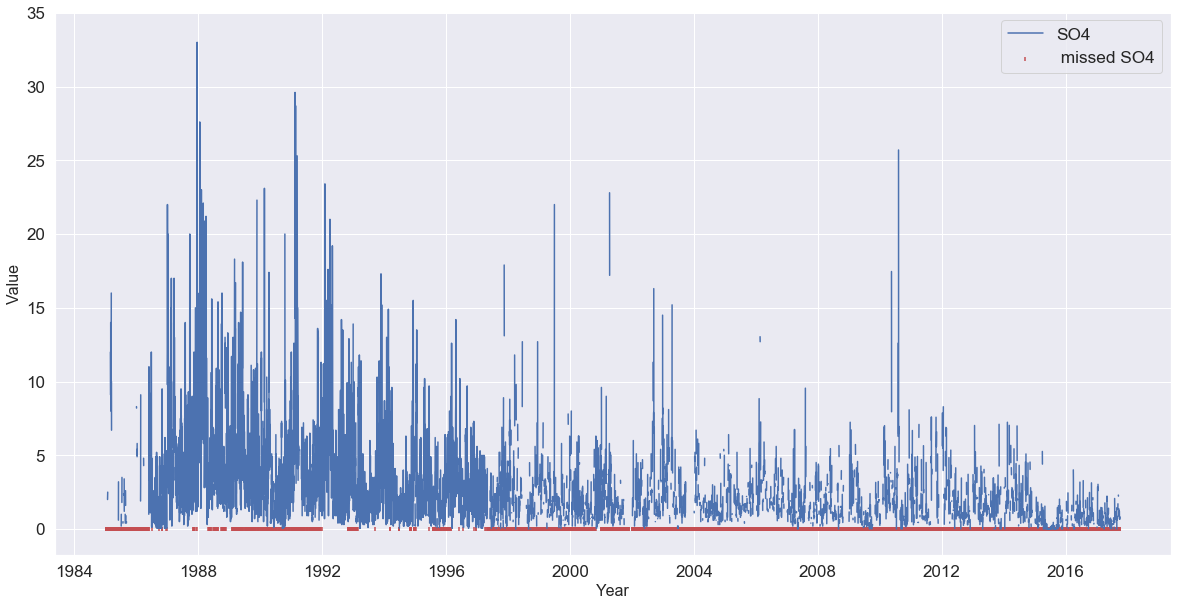

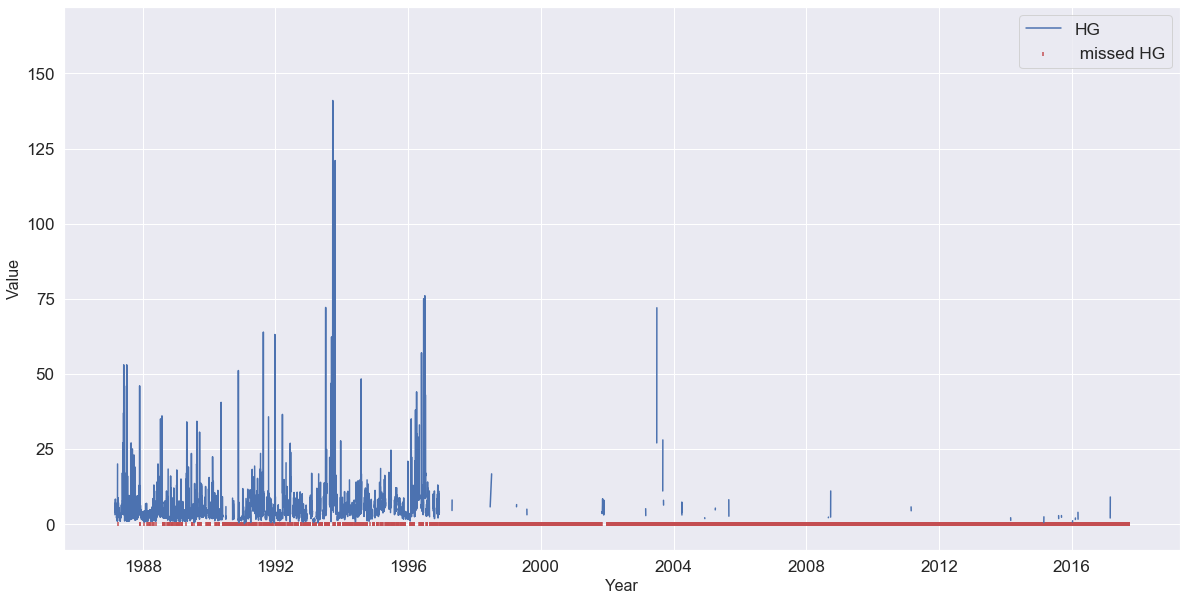

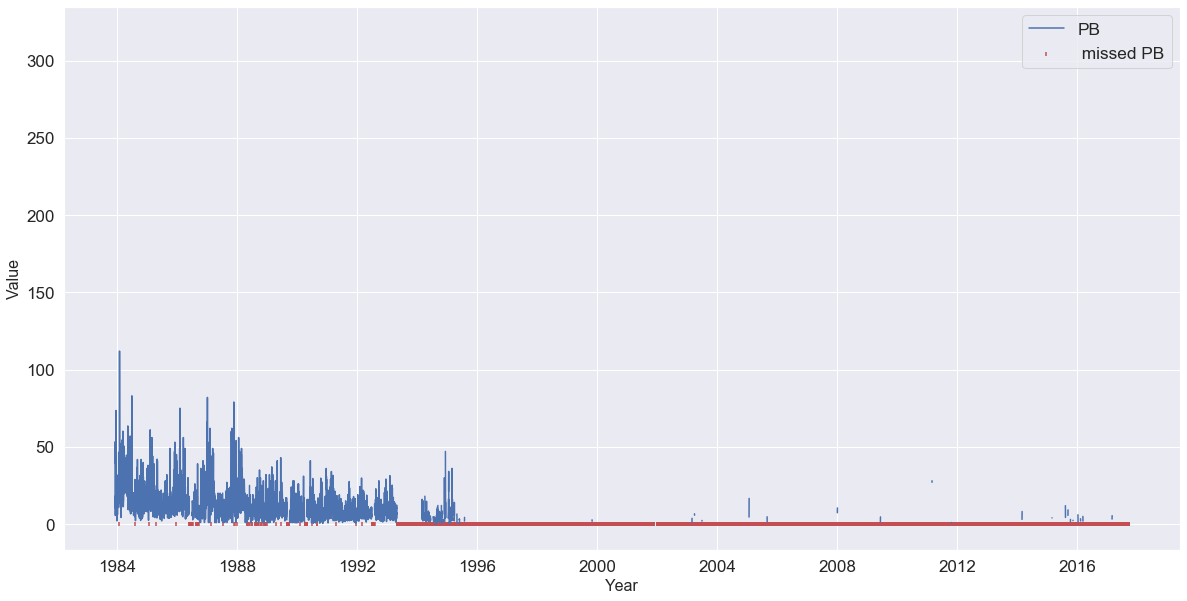

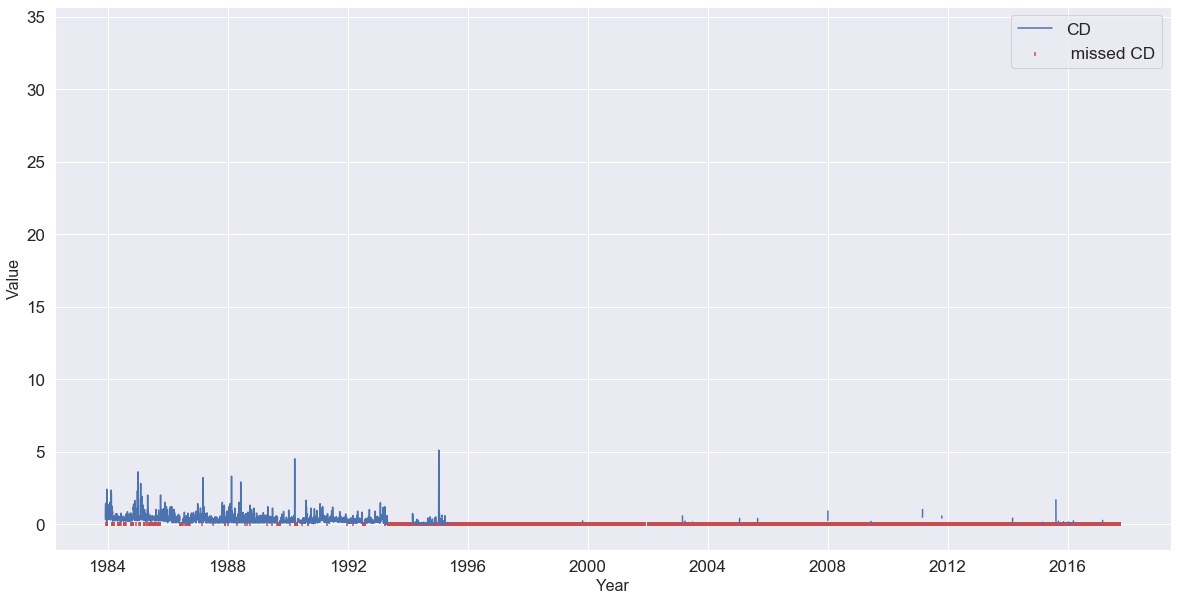

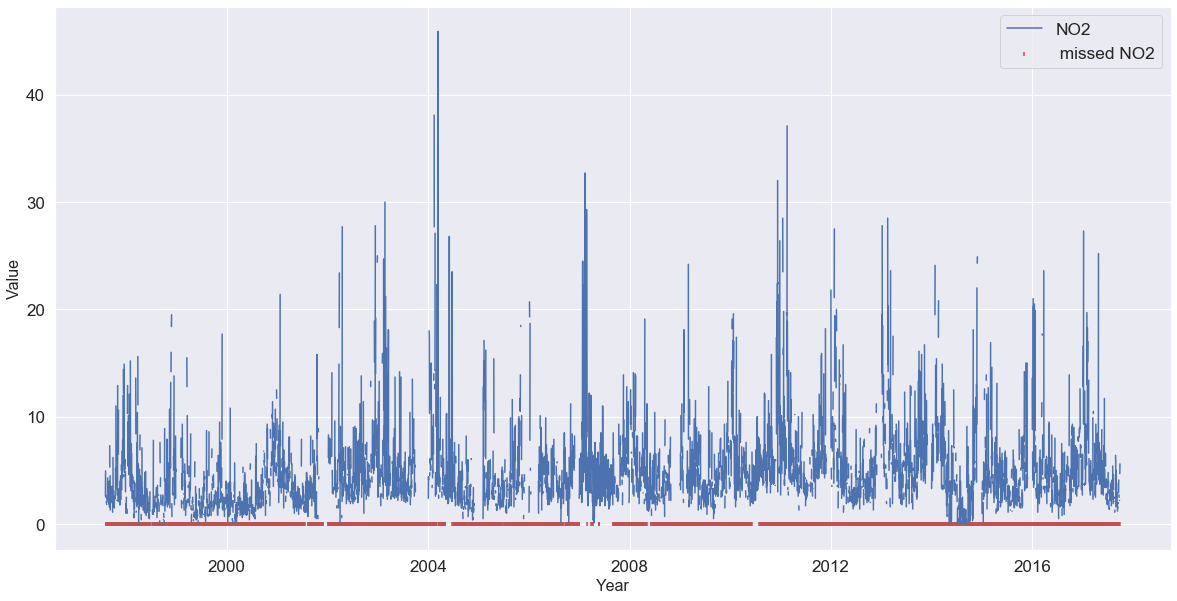

In [190]:
for col in df.columns:
    #get ts for specific column
    ts = df[[col]].copy()
    #get valid indexes of 1-st and last appearance for the column
    fir_ix = ts.index.get_loc(ts[col].first_valid_index())
    last_ix = ts.index.get_loc(ts[col].last_valid_index())
    ts = ts.iloc[fir_ix:last_ix+1, :]
    
    #plot
    plt.figure(figsize=(20,10))
    #plot true given elements
    plt.plot(ts.index, ts[col], label=f"{col}")
    #plot epsilon around zero where missing values are (nan)
    ts['nan'] = np.where(ts[col].isna(), 1e-5, np.nan)
    plt.scatter(ts.index, ts['nan'], color='r', label=f" missed {col}",  marker='|', s=10)
    plt.legend(loc='best', fontsize='x-large')
    plt.ylabel('Value', fontsize=16)
    plt.xlabel('Year', fontsize=16)
    plt.tick_params(labelsize=17)
    
plt.show()

**It seems $SO_2$ is the most appropriate to work with**

Save it and try to preprocess for forecasting in another file

In [66]:
col = 'SO2'
ts = df[[col]].copy()
#olny valid dates are needed
fir_ix = ts.index.get_loc(ts[col].first_valid_index())
last_ix = ts.index.get_loc(ts[col].last_valid_index())
ts = ts.iloc[fir_ix:last_ix+1, :]

In [67]:
path = os.path.join('data', 'best_ts.csv')
ts.to_csv(path)